# PCAによる異常検知の実装例
* scikit-learnのライブラリにあるため、それを利用する。

In [65]:
# !pip install japanize-matplotlib

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# import japanize_matplotlib
import seaborn as sns

## 正規分布データに対する異常検知


In [41]:
# ダミーデータ作成
np.random.seed(42)

# 変数生成
ph = np.round(np.random.uniform(4, 10, 2000), 1)          # ph: 4~10, 小数点1桁
water_temp = np.round(np.random.uniform(10, 60, 2000), 0) # water_temp: 10~60, 小数点0桁
rain = np.round(np.random.uniform(0, 100, 2000), 0)       # rain: 0~100, 小数点0桁
cod = np.round(np.random.uniform(0, 10, 2000), 1)         # COD: 0~10, 小数点1桁

data_df = pd.DataFrame({
    'ph': ph,
    'water_temp': water_temp,
    'rain': rain,
    'cod': cod
})

# 正常範囲データ抽出
sampled_data = data_df[
    (data_df['ph'] >= 6) &
    (data_df['ph'] <= 10) &
    (data_df['water_temp'] <= 35) &
    (data_df['rain'] <= 25) &
    (data_df['cod'] <= 5)
]
sampled_data.describe()

,ph,water_temp,rain,cod
count,98.000000,98.000000,98.000000,98.000000
mean,7.875510,23.255102,13.142857,2.423469
std,1.174827,7.757020,7.539586,1.486420
min,6.000000,10.000000,0.000000,0.000000
25%,6.900000,16.250000,7.000000,1.000000
50%,7.800000,23.000000,14.000000,2.350000
75%,8.750000,30.000000,19.000000,3.700000
max,10.000000,35.000000,25.000000,4.900000


In [57]:
# 標準化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(sampled_data)
df_scaled = pd.DataFrame(df_scaled, columns=sampled_data.columns)

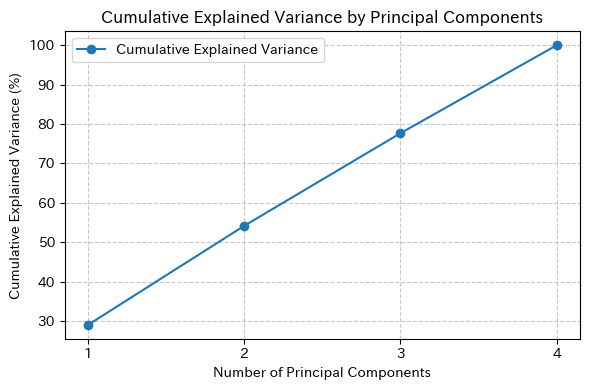

In [58]:
# 主成分数の検討
pca = PCA(n_components=df_scaled.shape[1])  # 最大で元の次元数まで
pca.fit(df_scaled)

# 寄与率と累積寄与率の計算
explained_variance_ratio = pca.explained_variance_ratio_  # 各主成分の寄与率
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)  # 累積寄与率

# 可視化
plt.figure(figsize=(6, 4))

# 累積寄与率を点と線でプロット
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio * 100, '-o', label='Cumulative Explained Variance')

# グラフの装飾
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))  # 主成分番号をx軸に設定
plt.legend(loc='best')
plt.tight_layout()
plt.show()

* 主成分数は3に決定

In [59]:
# PCA適用

# 主成分数
n_components = 3

pca = PCA(n_components=n_components).fit(df_scaled)
pcad_data = pca.transform(df_scaled)

pcad_data[:5]

array([[-1.43514709,  0.47721923,  0.72321388],
       [-0.21354034,  1.99109316,  1.18952632],
       [-0.73355894, -1.11919495,  1.22032468],
       [-0.10598409, -0.33959497, -1.56978653],
       [-1.15607606,  0.57198539,  0.57854514]])

In [60]:
# 異常度算出（再構成誤差の2乗和）
inved_data = pca.inverse_transform(pcad_data)
anomaly_score = np.sum((df_scaled.values - inved_data) ** 2, axis=1)

df_scaled['anomaly_score'] = anomaly_score

In [61]:
df_scaled['anomaly_score'].describe()

,anomaly_score
count,98.000000
mean,0.893315
std,1.140190
min,0.000016
25%,0.107222
50%,0.460426
75%,1.202212
max,4.942223


* 最大値より大きなスコアが出たら異常値とする

In [62]:
# 判別対象レコードのデータフレーム作成
target_df = pd.DataFrame({
    'ph': [2, 7, 8, 7, 7],
    'water_temp': [30, 55, 24, 55, 25],
    'rain': [0, 0, 80, 0, 0],
    'cod': [2, 1, 1, 10, 1]
})
target_df

,ph,water_temp,rain,cod
0,2,30,0,2
1,7,55,0,1
2,8,24,80,1
3,7,55,0,10
4,7,25,0,1


In [64]:
# 標準化
test_scaled = scaler.transform(target_df)

# PCA適用
test_pcad_data = pca.transform(test_scaled)

# 異常度算出
test_inved_data = pca.inverse_transform(test_pcad_data)
test_anomaly_score = np.sum((test_scaled - test_inved_data) ** 2, axis=1)

# 判定
anomalies = test_anomaly_score > df_scaled['anomaly_score'].max()

# 結果格納
result = pd.DataFrame({
    'anomaly_score': test_anomaly_score,
    'is_anomaly': anomalies,
    '正解値': ['異常', '異常','異常','異常','正常']
})
result

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,anomaly_score,is_anomaly,正解値
0,19.976788,True,異常
1,1.464056,False,異常
2,45.274173,True,異常
3,1.894922,False,異常
4,3.011017,False,正常


* 残念ながら、4つの異常のうち2つしか正解していない。